In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import ase
import matplotlib.pyplot as plt
import numpy as np

import abtem

abtem.config.set({"local_diagnostics.progress_bar": True});

(tutorials:partial_coherence)=
# Partial coherence

In our [walkthrough on the contrast transfer function](walkthrough:contrast_transfer_function), we described how partial coherence may be approximated by multiplication with an envelope function. This approach is not always appropriate for simulating experiments with plane wave illumination and it is never appropriate for simulating experiments with a convergent beam. In this walkthrough, we cover a more accurate approach and compare fully coherent, quasi-coherent and incoherent simulations.

## Partial coherence with plane waves

When imaging with plane waves, partial temporal coherence (due to energy spread) is generally much more important than partial spatial coherence (due to source size). For this reason, our walkthrough will focus on partial temporal coehrence. 

As a test system, we simulate an exit wave at $80 \ \mathrm{keV}$ using a sample of MoS<sub>2</sub>.

In [2]:
atoms = ase.build.mx2(vacuum=2)

plane_wave = abtem.PlaneWave(energy=80e3, sampling=0.05)

exit_wave = plane_wave.multislice(atoms)

We first do the coherent and quasi-coherent simulations, we use Scherzer defocus with a spherical aberration of $-20 \ \mu m$ and a focal spread of $52.50 \ \mathrm{Å}$. An identical simulation was already performed in the [walkthrough on the CTF](walkthrough:contrast_transfer_function).

In [3]:
energy = 80e3
Cs = -20e-6 * 1e10
focal_spread = 52.50

# Simulate coherent image
ctf_coherent = abtem.CTF(Cs=Cs, energy=energy)
ctf_coherent.defocus = ctf_coherent.scherzer_defocus
ctf_coherent.semiangle_cutoff = ctf_coherent.crossover_angle
image_coherent = exit_wave.apply_ctf(ctf_coherent).intensity().compute()

# Create CTF with temporal coherence envelope
ctf_quasi_coherent = ctf_coherent.copy()
ctf_quasi_coherent.focal_spread = focal_spread

# Run multislice and get intensity
image_quasi_coherent = exit_wave.apply_ctf(ctf_quasi_coherent).intensity().compute()

[########################################] | 100% Completed | 1.47 ss
[########################################] | 100% Completed | 113.64 ms


In the fully incoherent model of partial temporal coherence, we integrate over the image intensity at different defocii 

$$
    I_{incoherent} = \int_{-\infty}^{\infty} p(\Delta f) I(\Delta f) \ \mathrm{d} \Delta f \quad ,
$$ (eq:incoherent_integral)

where the image intensity at a defocus, $\Delta f$, is given as

$$
    I(\Delta f) = \left\| \mathcal{F^{-1}}\left[ \hat{\psi}_{exit} \exp(-i \chi(\Delta f) \right] \right\|^2 \quad ,
$$

where, $\psi_{exit}$, is the exit wave function and $\chi(\Delta f)$ is the phase aberrations at $\Delta f$. For clarity we have omitted both real and reciprocal space coordinates.

The weighting function, $p(\Delta f)$, is assumed to be Gaussian

$$
    p(\Delta f) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{(\Delta f_{center} - \Delta f) ^ 2}{2\sigma ^ 2}\right) \quad ,
$$ (eq:gaussian_weights)

where $\sigma$ is the focal spread (equivalent to `focal_spread` in the quasi-coherent model).

We can approximate Eq. {eq}`eq:incoherent_integral` as a Riemann sum

$$
    I_{incoherent} = \sum_{\Delta f_n} p(\Delta f_n) I(\Delta f_n)
$$

where we need to choose a set of $N$ samples 

$$
    \Delta f_n = \Delta f_{center} - \Delta f_{truncation} + \frac{2 n \Delta f_{truncation}}{N}
$$

where $n=0,1,\ldots,N$. The Gaussian is unbounded, however, we may assume that contributions beyond a chosen truncation, $\Delta f_{truncation}$, are small enough to be neglected.


To calculate this in abTEM, we create the distribution in Eq. {eq}`eq:gaussian_weights` using `abtem.distributions.gaussian`, we can then copy the coherent CTF from above and set the `defocus` to this distribution. The center of the distribution is set to the Scherzer defocus ($\Delta f_0 = 111.92 \ \mathrm{Å}$) and the standard deviation is set to the focal spread ($\sigma = 52.5 \ \mathrm{Å}$). The truncation of the Riemann sum set to $\Delta f_{truncation} = 1.5 \sigma = 78.75 \ \mathrm{Å}$ and we use $N=7$ linearly spaced samples. This was found to be sufficent for a reasonably converged simulation. 

In [4]:
defocus_distribution = abtem.distributions.gaussian(
    center=ctf_coherent.defocus,
    standard_deviation=focal_spread,
    num_samples=7,
    sampling_limit=1.5,
)

ctf_incoherent = ctf_coherent.copy()
ctf_incoherent.defocus = defocus_distribution

We apply the CTF as usual and calculate the intensity, obtaining the ensemble of images representing $p(\Delta f_n) I(\Delta f_n)$ for each defocus sample.

In [5]:
images_incoherent = exit_wave.apply_ctf(ctf_incoherent).intensity()

images_incoherent.compute()

images_incoherent.axes_metadata

[########################################] | 100% Completed | 118.31 ms


type           label    coordinates
-------------  -------  -----------------------
ParameterAxis  C10 [Å]  190.67 164.42 ... 33.17
RealSpaceAxis  x [Å]    0.00 0.05 ... 3.13
RealSpaceAxis  y [Å]    0.00 0.05 ... 5.46

We show the ensemble of images below, we see that the image intensity has the highest weight at $\Delta f_0 = 111.92 \ \mathrm{Å}$ and drops off to almost zero at $\Delta f_0 \pm \Delta f_{truncation}$.

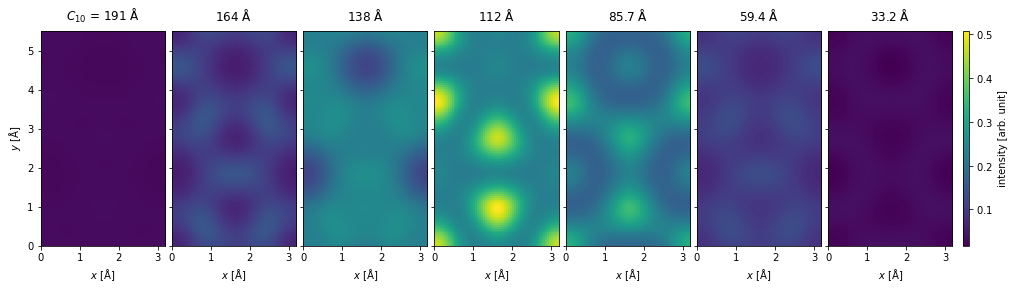

In [6]:
images_incoherent.show(
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
);

To obtain the incoherent image, we sum across the image ensemble.

In [7]:
image_incoherent = images_incoherent.sum(0)

We show a comparison between the fully coherent, the quasi-coherent and the incoherent summation below. We see that while the quasi-coherent approximation is qualitatively similar to the incoherent summation, there is clear quantitative differences between the two models. 

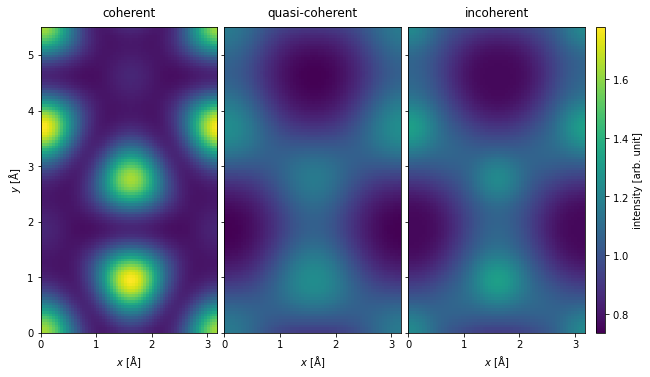

In [8]:
stack = abtem.stack(
    [image_coherent, image_quasi_coherent, image_incoherent],
    ("coherent", "quasi-coherent", "incoherent"),
)

stack.show(
    common_color_scale=True,
    explode=True,
    cbar=True,
    figsize=(18, 5),
);

The quantitative differences are clearer when shown as a line profile.

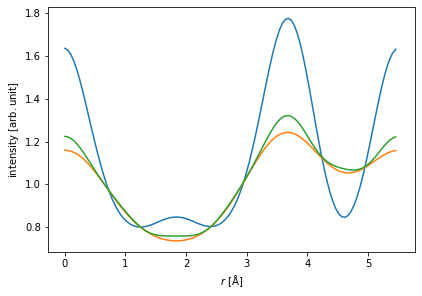

In [9]:
stack.interpolate_line(start=(0, 0), end=(0, stack.extent[1])).show();

It should be noted that the quasi-coherent model is better for smaller focal spread, hence, it may be more appropriate at higher electron energies.

## Partial coherence with probes

We can also simulate partial temporal coherence using probe wave functions using the weighted incoherent integral in Eq. {eq}`eq:incoherent_integral`. However, we now have to integrate over the initial conditions of the wave functions

$$
    \hat{I}(\Delta f) = \left\| p(\Delta f) \mathcal{M} \left[\hat{\psi}_0(\Delta f) \right] \right\|^2 \quad ,
$$

where $\mathcal{M}$ is the multislice operator, defined in Eq. {eq}`eq:multislice_symbol` in the [walkthrough on multislice](walkthrough:multislice). This means that a run of the multislice algorithm is required for every $\Delta f_n$ sample, and hence, including temporal partial incoherence can be expensive.

Partial spatial coherence can be simulated by a weighted integral over source positions. For a probe at the position, $(x_0, y_0)$, we have to do a 2D integral over the probe displacements $(\Delta x, \Delta y)$

$$
    \hat{I}_{incoherent}(x_0, y_0) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} p(\Delta x, \Delta y) \hat{I}(x_0 + \Delta x, y_0 + \Delta y) \mathrm{d} \Delta x \mathrm{d} \Delta y \quad ,
$$ (eq:incoherent_integral_spatial)

where each image is given as
$$
    \hat{I}(\Delta x, \Delta y) = \left\| p(\Delta x, \Delta y) \mathcal{M} \left[\psi_0(x_0 + \Delta x, y_0 + \Delta y) \right] \right\|^2 \quad .
$$

Performing this 2D integral as a Riemann sum is very expensive. Fortunately, in scanning TEM, we already have to simulate a dense sampling of probe positions. Hence, we can just use those samples, this is equivalent to applying a Gaussian filter, and thus partial spatial coherence is almost free in scanning TEM.

This trick obviously does not work for simulating diffraction with single probes, such as CBED, however, in CBED we typically use a small aperture, making partial spatial incoherence insignificant.

As a test system, we simulate a 4D-STEM dataset at $80 \ \mathrm{keV}$ using a sample of MoS<sub>2</sub>. First, we create a model of MoS<sub>2</sub>, large enough to accomodate the size of our probe.

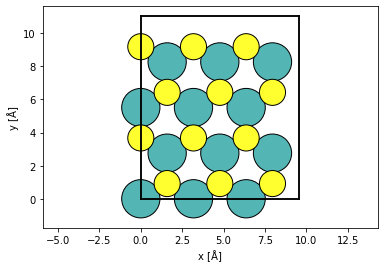

In [10]:
atoms = ase.build.mx2(vacuum=2)

atoms = abtem.orthogonalize_cell(atoms) * (3, 2, 1)

abtem.show_atoms(atoms);

Next, we create the probe.

In [11]:
energy = 80e3
probe_coherent = abtem.Probe(energy=energy, semiangle_cutoff=30, sampling=0.05)

We define a Gaussian distribution over the defocus. Given an energy spread of $\Delta E = 0.15 \ \mathrm{eV}$, a chromatic aberration of $1 \ \mathrm{mm}$, the standard deviation of the Gaussian is

$$
\delta = C_c \frac{\Delta E}{E} = 18.75 \ \mathrm{Å} \ \quad .
$$

In [12]:
chromatic_aberration = 1.0 * 1e-3 * 1e10
energy_spread = 0.15
focal_spread = chromatic_aberration * energy_spread / energy

defocus_distribution = abtem.distributions.gaussian(
    center=0.0,
    standard_deviation=focal_spread,
    num_samples=11,
    sampling_limit=2,
    ensemble_mean=False,
)

print("Focal spread =", focal_spread, "Å")

Focal spread = 18.75 Å


We run the multislice simulations, see our walkthrough for details.

In [13]:
probe_temporal = abtem.Probe(
    energy=energy, semiangle_cutoff=30, sampling=0.05, defocus=defocus_distribution
)

detector = abtem.PixelatedDetector()

scan = abtem.GridScan(
    (0, 0),
    (1 / 3, 1 / 2),
    fractional=True,
    potential=atoms
)

In [14]:
measurement_coherent = probe_coherent.scan(
    atoms, detectors=detector, scan=scan
).compute()

measurement_temporal = probe_temporal.scan(
    atoms, detectors=detector, scan=scan
).compute()

[########################################] | 100% Completed | 3.50 sms
[########################################] | 100% Completed | 7.66 ss


Partial spatial coherence is added using the `gaussian_source_size` method which applies a gaussian blur accross the scan dimensions. We emphasize that we do not blur individual diffraction patterns, rather we mix adjacent diffraction patterns weighted by a gaussian as a function of the distance between the probe position at which the pattern was collected.

In [15]:
source_size = 0.3

measurement_spatial = measurement_coherent.gaussian_source_size(source_size)
measurement_temporal_spatial = measurement_temporal.gaussian_source_size(source_size)

We stack the `DiffractionPatterns` for more convenient plotting.

In [16]:
stacked = abtem.stack(
    (
        measurement_coherent,
        measurement_temporal,
        measurement_spatial,
        measurement_temporal_spatial,
    ),
    ("coherent", "temporal", "spatial", "temporal + spatial"),
)

We select the diffraction patterns with the index `(1, 1)`, i.e. the patterns collected to the upper right of the Mo atom. We crop the diffraction patterns to just above the bright field disk and plot them on an exploded plot.

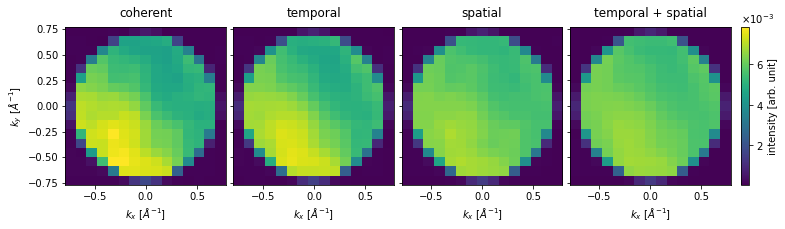

In [17]:
stacked[:, 1, 1].crop(30).show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    cbar=True,
);

It is immediately clear that partial coherence reduces the contrast in the diffraction patterns. 

Next we show the medium angle scattering intensity. It should be noted that the order in which the the `integrate_radial` and the `gaussian_source_size` methods are applied does not matter.

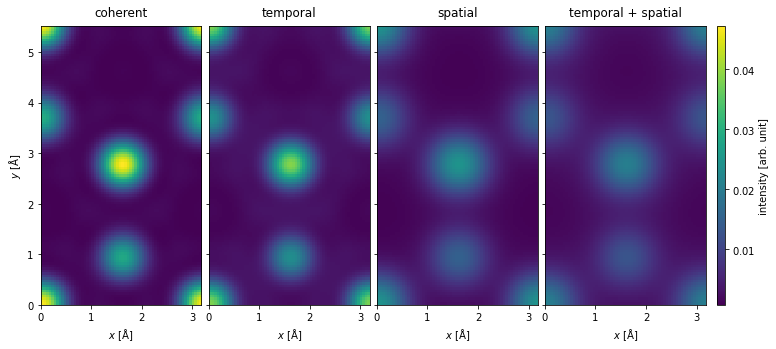

In [18]:
stacked.integrate_radial(50, 150).interpolate(0.05).show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    cbar=True,
);

Finally we show the absolute value of the center of mass

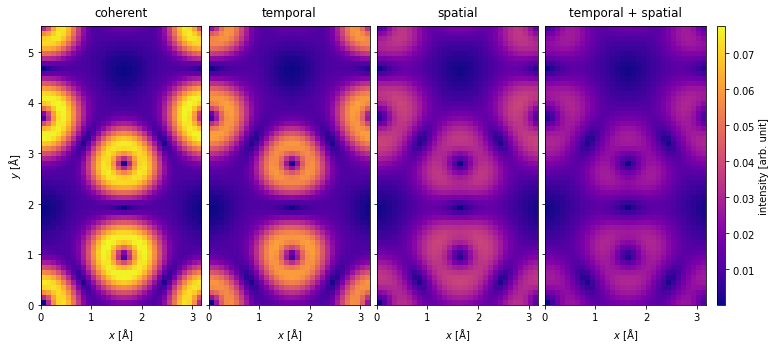

In [19]:
stacked.center_of_mass().interpolate(0.1).abs().show(
    figsize=(12, 6),
    explode=True,
    common_color_scale=True,
    cbar=True,
    cmap="plasma",
);

The preceding results show that partial spatial coherence is very important, we see that it both lowers the contrast and generally changes both the integrated and COM images. Partial temporal coherence, even at this low energy, had a less important role and its main main contribution was to lower the contrast. We should also note that the cost of including partial spatial coherence is almost non-existent, whereas partial temporal coherence may give a $\sim 10 x$ overhead.
